In [1]:
import pandas as pd
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
import time
import asyncio
import httpx
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import time

In [ ]:


df=pd.read_csv("real_estate_progress.csv")
print(df.head())
print(df.shape)

   Købesum  Vær.  Byggeår        dato      stype     m2        btype  \
0  1398250     4     1956  27-05-2025  Fam. Salg   83.0   Fritidshus   
1  2620000     5     1972  27-05-2025  Alm. Salg  120.0     Rækkehus   
2  6450000     6     1906  27-05-2025  Alm. Salg  240.0  Landejendom   
3   460000     8     1908  27-05-2025      Andet  176.0        Villa   
4  2951000     5     1974  27-05-2025  Alm. Salg  143.0        Villa   

                    addresse  postnummer          by                  område  \
0  Nordmandsvej 12, Lyngsbæk        8400    Ebeltoft     Øst- og Midtjylland   
1           Rosenlyparken 80        2670       Greve  Hovedstaden, København   
2    Karlslunde Centervej 76        4030        Tune               Andre øer   
3              Hovedgaden 42        8763  Rask Mølle     Øst- og Midtjylland   
4             Kirkebakken 66        4621    Gadstrup               Andre øer   

     region                              full_address          x          y  
0   Jyll

In [ ]:


CONCURRENCY_LIMIT = 5
SAVE_FILE_NAME = 'real_estate_progress.csv'

async def get_coordinates_async(client, semaphore, index, address):
    async with semaphore:
        base_url = "https://api.dataforsyningen.dk/adresser"
        params = {'q': address, 'struktur': 'mini'}
        try:
            response = await client.get(base_url, params=params, timeout=15.0)
            response.raise_for_status()
            data = response.json()
            if data:
                return index, data[0]['x'], data[0]['y']
        except httpx.RequestError:
            pass
        return index, np.nan, np.nan

async def run_concurrent_processing(df):
    try:
        if 'full_address' not in df.columns:
            df['full_address'] = df['addresse'] + ', ' + df['postnummer'].astype(str) + ' ' + df['by']
        
        for col in ['x', 'y']:
            if col not in df.columns:
                df[col] = np.nan

        df_to_process = df[df['x'].isna() | df['y'].isna()].copy()
        
        if df_to_process.empty:
            print("No new coordinates to fetch.")
            return df
            
        processed_count = 0
        start_time = time.monotonic()
        semaphore = asyncio.Semaphore(CONCURRENCY_LIMIT)
        total_to_process = len(df_to_process)
        
        print(f"Found {total_to_process} addresses to process...")

        async with httpx.AsyncClient() as client:
            tasks = [
                get_coordinates_async(client, semaphore, index, row['full_address'])
                for index, row in df_to_process.iterrows()
            ]
            
            for i, future in enumerate(asyncio.as_completed(tasks)):
                index, x_coord, y_coord = await future
                df.loc[index, ['x', 'y']] = x_coord, y_coord
                
                if not pd.isna(x_coord):
                    processed_count += 1
                
                if (i + 1) % 100 == 0 or (i + 1) == total_to_process:
                    elapsed_time = time.monotonic() - start_time
                    rate_per_second = processed_count / elapsed_time if elapsed_time > 0 else 0
                    print(f"Processed {i+1}/{total_to_process} | Rate: {rate_per_second:.2f} coords/sec")
                
                if processed_count > 0 and processed_count % 10000 == 0:
                    print(f"--- Saving progress to {SAVE_FILE_NAME} at {processed_count} records ---")
                    df.to_csv(SAVE_FILE_NAME, index=False)
        
        # Save final results
        print(f"--- Processing complete! Saving final results to {SAVE_FILE_NAME} ---")
        df.to_csv(SAVE_FILE_NAME, index=False)
        print(f"Successfully processed {processed_count} coordinates and saved all results.")
        
        return df
    
    except KeyError as e:
        print(f"Error: A required column is missing: {e}. Please check your column names.")
        return df
    except Exception as e:
        print(f"Unexpected error occurred: {e}")
        # Save whatever progress we have in case of error
        print(f"--- Saving progress due to error ---")
        df.to_csv(SAVE_FILE_NAME, index=False)
        return df
await run_concurrent_processing(df)

Found 2076 addresses to process...
Processed 100/2076 | Rate: 0.00 coords/sec
Processed 200/2076 | Rate: 0.00 coords/sec
Processed 300/2076 | Rate: 0.00 coords/sec
Processed 400/2076 | Rate: 0.00 coords/sec
Processed 500/2076 | Rate: 0.00 coords/sec
Processed 600/2076 | Rate: 0.00 coords/sec
Processed 700/2076 | Rate: 0.00 coords/sec
Processed 800/2076 | Rate: 0.00 coords/sec


CancelledError: 

In [94]:
df=pd.read_csv("real_estate_progress.csv")
df=df.dropna()
df.to_csv("xydone.csv", index=False)

In [93]:
df=df.dropna()
df.to_csv("xydone.csv", index=False)

In [7]:
df=pd.read_csv("xydone.csv")


In [8]:
print(f"Date column dtype: {df['dato'].dtype}") #object 
df['dato'] = pd.to_datetime(df['dato'])
print(f"Date column dtype: {df['dato'].dtype}") 
df = df.sort_values('dato')
df = df.set_index('dato')

Date column dtype: object
Date column dtype: datetime64[ns]


/var/folders/b1/kvks3q1d3118skc52j7g3pd40000gn/T/ipykernel_1247/1644463191.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['dato'] = pd.to_datetime(df['dato'])


In [82]:
print(df.index)

DatetimeIndex(['1996-06-03', '1996-06-03', '1996-06-03', '1996-06-03',
               '1996-06-03', '1996-06-03', '1996-06-03', '1996-06-03',
               '1996-06-03', '1996-06-03',
               ...
               '2025-06-02', '2025-06-02', '2025-06-02', '2025-06-02',
               '2025-06-02', '2025-06-02', '2025-06-02', '2025-06-02',
               '2025-06-02', '2025-06-02'],
              dtype='datetime64[ns]', name='dato', length=1557121, freq=None)


In [9]:

# Calculate the price per square meter
df['pris_pr_m2'] = df['Købesum'] / df['m2']


df = df.sort_index()

# Define the geographic levels and time windows for the rolling means
geo_levels = ['by', 'postnummer', 'område', 'region']
time_windows = ['30D', '180D', '365D']

# Calculate the rolling means for price per square meter
for level in geo_levels:
    for window in time_windows:
        new_col_name = f'pris_pr_m2_mean_{window}_{level}'
        
        df[new_col_name] = df.groupby(level)['pris_pr_m2'].transform(
            lambda x: x.rolling(window, min_periods=1, closed='left', ).mean()
        ).fillna(0)
        print(f"Calculated: {new_col_name}")



Calculated: pris_pr_m2_mean_30D_by
Calculated: pris_pr_m2_mean_180D_by
Calculated: pris_pr_m2_mean_365D_by
Calculated: pris_pr_m2_mean_30D_postnummer
Calculated: pris_pr_m2_mean_180D_postnummer
Calculated: pris_pr_m2_mean_365D_postnummer
Calculated: pris_pr_m2_mean_30D_område
Calculated: pris_pr_m2_mean_180D_område
Calculated: pris_pr_m2_mean_365D_område
Calculated: pris_pr_m2_mean_30D_region
Calculated: pris_pr_m2_mean_180D_region
Calculated: pris_pr_m2_mean_365D_region


In [113]:
df.tail(1000010)

,Købesum,Vær.,Byggeår,stype,m2,btype,addresse,postnummer,by,område,...,pris_pr_m2_mean_365D_by,pris_pr_m2_mean_30D_postnummer,pris_pr_m2_mean_180D_postnummer,pris_pr_m2_mean_365D_postnummer,pris_pr_m2_mean_30D_område,pris_pr_m2_mean_180D_område,pris_pr_m2_mean_365D_område,pris_pr_m2_mean_30D_region,pris_pr_m2_mean_180D_region,pris_pr_m2_mean_365D_region
dato,,,,,,,,,,,,,,,,,,,,,
2012-04-15,750000,4,1965,Alm. Salg,142.0,Villa,"Kærvej 6, Hvalpsund",9640,Farsø,Nordjylland,...,10012.825651,8238.863524,11677.901287,10012.825651,24361.485601,23284.881512,20204.213327,20628.455793,19687.108245,19455.668529
2012-04-15,1185000,2,1974,Alm. Salg,64.0,Ejerlejlighed,"Drejøgade 26E, 2. 201",2100,København Ø,"Hovedstaden, København",...,63154.038544,27311.496259,64210.242194,63154.038544,25926.513554,32595.154902,31161.545886,19286.380564,25502.070927,24635.889244
2012-04-15,650000,5,1964,Alm. Salg,135.0,Villa,Tulipanvej 10,6900,Skjern,Sydjylland,...,12151.995340,5956.214790,8881.756087,12151.995340,12535.403078,14893.032299,16652.753483,20628.455793,19687.108245,19455.668529
2012-04-15,790000,2,1973,Alm. Salg,57.0,Rækkehus,Majsvej 36,5800,Nyborg,Fyn og øer,...,17223.668155,9511.685380,12509.831038,17223.668155,11992.479905,17177.188677,16954.831096,11992.479905,17177.188677,16954.831096
2012-04-15,748000,5,1978,Fam. Salg,149.0,Villa,"Sybillesvej 44, Korinth",5600,Faaborg,Fyn og øer,...,10738.555574,12155.910206,12092.713896,10738.555574,11992.479905,17177.188677,16954.831096,11992.479905,17177.188677,16954.831096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02,775000,3,1969,Alm. Salg,103.0,Villa,Julsgårdsvej 8,7430,Ikast,Sydjylland,...,14930.084034,12620.233442,15055.312163,14930.084034,14632.627519,18307.604621,18518.114270,17483.881715,20499.835575,20524.089239
2025-06-02,6600000,6,1885,Alm. Salg,194.0,Ejerlejlighed,"Gammel Lundtoftevej 22, st. th",2800,Kongens Lyngby,"Hovedstaden, København",...,47989.788057,49245.933144,47847.539463,47989.788057,45277.049229,49103.648894,48922.527113,33116.267567,34805.712814,35100.397527
2025-06-02,575000,6,1979,Alm. Salg,177.0,Villa,"Vesterhavsvej 67, Vedersø",6990,Ulfborg,Sydjylland,...,13970.923013,6142.233605,13645.448576,13970.923013,14632.627519,18307.604621,18518.114270,17483.881715,20499.835575,20524.089239


In [10]:
df.to_csv("afterlag.csv")

In [2]:
df = pd.read_csv("afterlag.csv")
df = df.sort_values('dato')
df = df.set_index('dato')


In [3]:
df.tail(10)
df.index = pd.to_datetime(df.index)

In [ ]:


def generate_neighbor_features_vectorized(df: pd.DataFrame, k_values: list, closeness_feature_cols: list, value_col: str, date_col='dato', lookback_days=365):
    print("--- Starting vectorized neighbor feature generation ---")
    start_time = time.time()

    print(f"Scaling {len(df)} rows across {len(closeness_feature_cols)} features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[closeness_feature_cols])
    
    max_k = max(k_values)
    query_k = max_k * 4

    print(f"Fitting NearestNeighbors model with query_k={query_k}...")
    nn_model = NearestNeighbors(n_neighbors=query_k, metric='minkowski', p=2)
    nn_model.fit(X_scaled)
    fit_time = time.time()
    print(f"Model fitting complete in {fit_time - start_time:.2f} seconds.")

    print("Querying for neighbors for all properties (this may take a moment)...")
    distances, indices = nn_model.kneighbors(X_scaled)
    query_time = time.time()
    print(f"Neighbor query complete in {query_time - fit_time:.2f} seconds.")

    print("Starting processing of individual properties...")
    all_results = []
    
    all_dates = df.index.values
    all_values = df[value_col].values
    total_rows = len(df)
    loop_start_time = time.time()

    for i in range(total_rows):
        if (i + 1) % 50000 == 0:
            elapsed = time.time() - loop_start_time
            rate = (i + 1) / elapsed if elapsed > 0 else 0
            print(f"--- Processed {i + 1} / {total_rows} properties ({rate:.0f} rows/sec) ---")

        target_date = all_dates[i]
        neighbor_indices = indices[i]
        neighbor_dates = all_dates[neighbor_indices]
        
        time_window_mask = (neighbor_dates < target_date) & \
                           (neighbor_dates >= (target_date - pd.Timedelta(days=lookback_days)))
        
        valid_neighbor_indices = neighbor_indices[time_window_mask]
        
        row_stats = {}
        for k in k_values:
            final_indices = valid_neighbor_indices[:k]
            
            num_neighbors = len(final_indices)

            if num_neighbors > 0:
                neighbor_values = all_values[final_indices]
                row_stats[f'mean_of_{k}_neighbors_{value_col}'] = np.mean(neighbor_values)
                row_stats[f'std_of_{k}_neighbors_{value_col}'] = np.std(neighbor_values)
            else:
                row_stats[f'mean_of_{k}_neighbors_{value_col}'] = np.nan
                row_stats[f'std_of_{k}_neighbors_{value_col}'] = np.nan
        
        all_results.append(row_stats)
    
    print(f"Processing complete. Finalizing DataFrame...")
    end_time = time.time()
    print(f"--- Vectorized neighbor feature generation finished in {(end_time - start_time)/60:.2f} minutes ---")

    return pd.DataFrame(all_results, index=df.index)

# --- Example Usage ---

# Make sure your DataFrame is sorted by date and has a DatetimeIndex
# df = df.sort_values('dato')
# df = df.set_index('dato')

# Define your parameters
K_VALUES = [5, 10, 25, 50]
CLOSENESS_FEATURES = ['x', 'y'] 
VALUE_COL = 'pris_pr_m2'

# Generate the features using the fast, vectorized function
neighbor_features_df = generate_neighbor_features_vectorized(
    df=df,
    k_values=K_VALUES,
    closeness_feature_cols=CLOSENESS_FEATURES,
    value_col=VALUE_COL
)
print("Neighbor features generated successfully.")
# Join the new features back to your original DataFrame
df_with_neighbors = pd.concat([df, neighbor_features_df], axis=1)
print("Joined neighbor features to the original DataFrame.")
# Display the first few rows with the new features
print(df_with_neighbors.head())


--- Starting vectorized neighbor feature generation ---
Scaling 1557121 rows across 2 features...
Fitting NearestNeighbors model with query_k=200...
Model fitting complete in 0.37 seconds.
Querying for neighbors for all properties (this may take a moment)...
Neighbor query complete in 27.03 seconds.
Starting processing of individual properties...
--- Processed 50000 / 1557121 properties (32933 rows/sec) ---
--- Processed 100000 / 1557121 properties (30886 rows/sec) ---
--- Processed 150000 / 1557121 properties (30292 rows/sec) ---
--- Processed 200000 / 1557121 properties (30001 rows/sec) ---
--- Processed 250000 / 1557121 properties (29716 rows/sec) ---
--- Processed 300000 / 1557121 properties (29481 rows/sec) ---
--- Processed 350000 / 1557121 properties (29266 rows/sec) ---
--- Processed 400000 / 1557121 properties (29134 rows/sec) ---
--- Processed 450000 / 1557121 properties (29024 rows/sec) ---
--- Processed 500000 / 1557121 properties (28983 rows/sec) ---
--- Processed 550000 /

In [ ]:
df_with_neighbors.tail(10)

,Købesum,Vær.,Byggeår,stype,m2,btype,addresse,postnummer,by,område,...,std_of_5_neighbors_pris_pr_m2,num_actual_10_neighbors_for_stats,mean_of_10_neighbors_pris_pr_m2,std_of_10_neighbors_pris_pr_m2,num_actual_25_neighbors_for_stats,mean_of_25_neighbors_pris_pr_m2,std_of_25_neighbors_pris_pr_m2,num_actual_50_neighbors_for_stats,mean_of_50_neighbors_pris_pr_m2,std_of_50_neighbors_pris_pr_m2
dato,,,,,,,,,,,,,,,,,,,,,
2025-06-02,2195000,4,1964,Alm. Salg,51.0,Fritidshus,Sleipnersvej 38,3210,Vejby,Nordsjælland,...,10423.034084,5,35425.726709,10423.034084,5,35425.726709,10423.034084,5,35425.726709,10423.034084
2025-06-02,5700000,4,1990,Alm. Salg,132.0,Ejerlejlighed,"Astilbehaven 137, 2. th",2830,Virum,"Hovedstaden, København",...,5781.922705,10,47162.013625,10520.800543,14,47624.919679,9672.206068,14,47624.919679,9672.206068
2025-06-02,12300000,5,1922,Alm. Salg,178.0,Villa,"Søllerødvej 50, Søllerød",2840,Holte,"Hovedstaden, København",...,7507.630226,5,57069.089801,7507.630226,5,57069.089801,7507.630226,5,57069.089801,7507.630226
2025-06-02,4950000,4,1972,Alm. Salg,126.0,Villa,Nederbyvej 13,2740,Skovlunde,"Hovedstaden, København",...,9495.719608,10,28597.892999,8741.110464,16,29346.619351,7138.289116,16,29346.619351,7138.289116
2025-06-02,539200,3,1950,Fam. Salg,68.0,Villa,"Kølkær Hovedgade 94, Kølkær",7400,Herning,Sydjylland,...,3590.207358,10,6495.426215,3288.143260,12,6192.328841,3108.874042,12,6192.328841,3108.874042


In [10]:
df_with_neighbors.to_csv("with_neighbors.csv")

In [11]:
df=df_with_neighbors

In [ ]:
rows_with_nan = df.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values: {rows_with_nan}")
df=df.dropna()


Number of rows with NaN values: 34777


In [14]:
df.head(10)

,Købesum,Vær.,Byggeår,stype,m2,btype,addresse,postnummer,by,område,...,std_of_5_neighbors_pris_pr_m2,num_actual_10_neighbors_for_stats,mean_of_10_neighbors_pris_pr_m2,std_of_10_neighbors_pris_pr_m2,num_actual_25_neighbors_for_stats,mean_of_25_neighbors_pris_pr_m2,std_of_25_neighbors_pris_pr_m2,num_actual_50_neighbors_for_stats,mean_of_50_neighbors_pris_pr_m2,std_of_50_neighbors_pris_pr_m2
dato,,,,,,,,,,,,,,,,,,,,,
1996-06-04,150000,3,1950,Alm. Salg,48.0,Fritidshus,Haulundsvej 90,9300,Sæby,Nordjylland,...,0.000000,1,2748.717949,0.000000,1,2748.717949,0.000000,1,2748.717949,0.000000
1996-06-05,921000,5,1978,Alm. Salg,181.0,Villa,"Femvej 12, Dybbøl",6400,Sønderborg,Sydjylland,...,0.000000,1,1125.827815,0.000000,1,1125.827815,0.000000,1,1125.827815,0.000000
1996-06-06,1000000,6,1999,Alm. Salg,172.0,Landejendom,Rolsøgårdvej 16,8420,Knebel,Øst- og Midtjylland,...,0.000000,1,4339.622642,0.000000,1,4339.622642,0.000000,1,4339.622642,0.000000
1996-06-06,799523,4,1934,Alm. Salg,116.0,Villa,Kong Eriks Vej 11A,9000,Aalborg,Nordjylland,...,0.000000,1,7950.544118,0.000000,1,7950.544118,0.000000,1,7950.544118,0.000000
1996-06-06,1040000,5,1979,Alm. Salg,140.0,Villa,Tyttebærvej 6,8850,Bjerringbro,Øst- og Midtjylland,...,2318.519519,3,2805.659787,2318.519519,3,2805.659787,2318.519519,3,2805.659787,2318.519519
1996-06-07,2432000,6,1910,Alm. Salg,193.0,Villa,Vallerødgade 4A,2960,Rungsted Kyst,"Hovedstaden, København",...,0.000000,1,8233.795455,0.000000,1,8233.795455,0.000000,1,8233.795455,0.000000
1996-06-08,400000,4,1963,Alm. Salg,82.0,Fritidshus,"Lærkestien 1, Furreby",9480,Løkken,Nordjylland,...,0.000000,1,5279.279279,0.000000,1,5279.279279,0.000000,1,5279.279279,0.000000
1996-06-08,355000,5,1970,Alm. Salg,69.0,Fritidshus,Margueritevej 3,4500,Nykøbing Sj,Andre øer,...,0.000000,1,1568.627451,0.000000,1,1568.627451,0.000000,1,1568.627451,0.000000
1996-06-09,665000,4,1906,Alm. Salg,116.0,Villa,Strandvejen 11,8721,Daugård,Øst- og Midtjylland,...,0.000000,1,1402.234043,0.000000,1,1402.234043,0.000000,1,1402.234043,0.000000


In [27]:
categorical_cols = ['område', 'stype', 'btype']

# Udfør one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)


In [29]:
cols_to_drop = [
    'addresse',
    'full_address',
    'by',
    'postnummer',
    'region',
    'x',
    'y'
]
df_cleaned = df_encoded.drop(columns=cols_to_drop).copy()


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
df_cleaned.columns

Index(['Købesum', 'Vær.', 'Byggeår', 'm2', 'pris_pr_m2',
       'pris_pr_m2_mean_30D_by', 'pris_pr_m2_mean_180D_by',
       'pris_pr_m2_mean_365D_by', 'pris_pr_m2_mean_30D_postnummer',
       'pris_pr_m2_mean_180D_postnummer', 'pris_pr_m2_mean_365D_postnummer',
       'pris_pr_m2_mean_30D_område', 'pris_pr_m2_mean_180D_område',
       'pris_pr_m2_mean_365D_område', 'pris_pr_m2_mean_30D_region',
       'pris_pr_m2_mean_180D_region', 'pris_pr_m2_mean_365D_region',
       'num_actual_5_neighbors_for_stats', 'mean_of_5_neighbors_pris_pr_m2',
       'std_of_5_neighbors_pris_pr_m2', 'num_actual_10_neighbors_for_stats',
       'mean_of_10_neighbors_pris_pr_m2', 'std_of_10_neighbors_pris_pr_m2',
       'num_actual_25_neighbors_for_stats', 'mean_of_25_neighbors_pris_pr_m2',
       'std_of_25_neighbors_pris_pr_m2', 'num_actual_50_neighbors_for_stats',
       'mean_of_50_neighbors_pris_pr_m2', 'std_of_50_neighbors_pris_pr_m2',
       'område_Bornholm', 'område_Fyn og øer', 'område_Hovedstaden, Kø

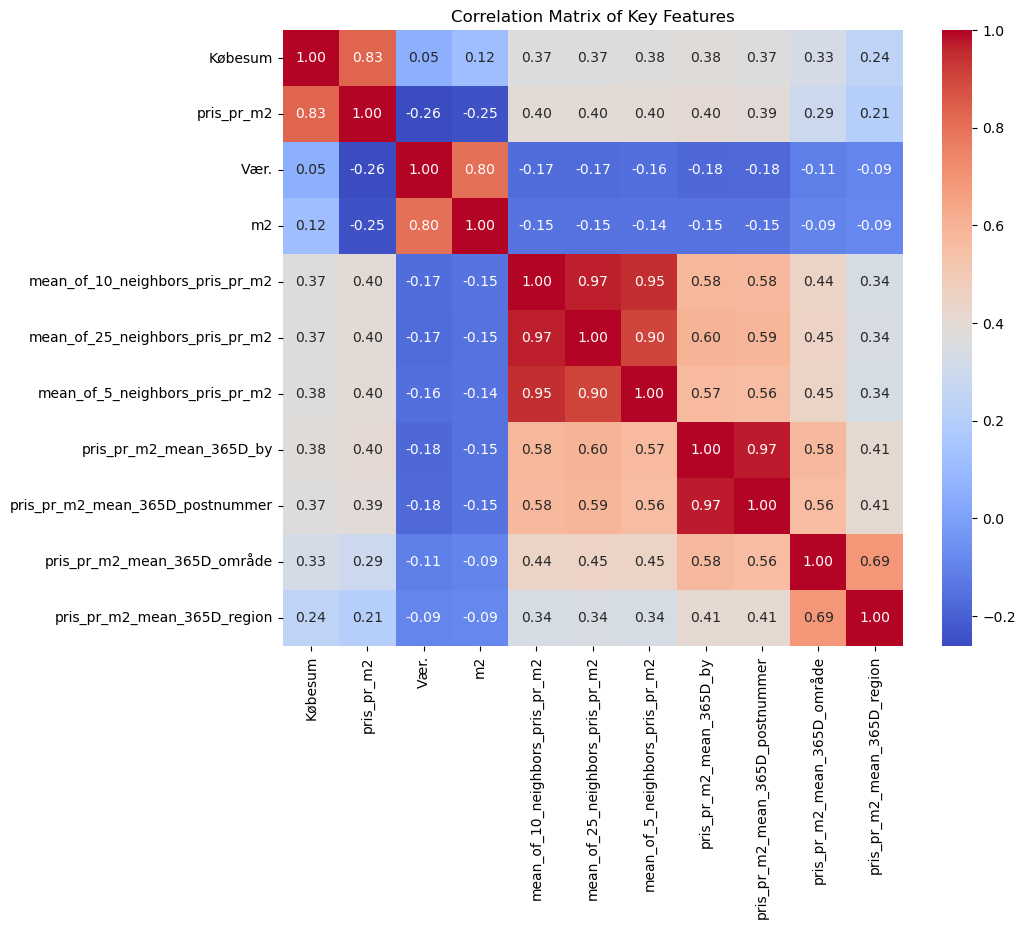

In [20]:
numerical_cols_for_corr = [
    'Købesum',
    'pris_pr_m2',
    'Vær.',
    'm2',
    'mean_of_10_neighbors_pris_pr_m2',
    'mean_of_25_neighbors_pris_pr_m2',
    'mean_of_5_neighbors_pris_pr_m2',
    'pris_pr_m2_mean_365D_by',
    'pris_pr_m2_mean_365D_postnummer',
    'pris_pr_m2_mean_365D_område',
    'pris_pr_m2_mean_365D_region',
   # 'age',
    #'date_ordinal'
]
correlation_matrix = df_cleaned[numerical_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()

/var/folders/b1/kvks3q1d3118skc52j7g3pd40000gn/T/ipykernel_2454/648886374.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Vær.', y='Købesum', data=df, estimator=np.mean, ci=None, color='#4c72b0')


<Axes: xlabel='Vær.', ylabel='Købesum'>

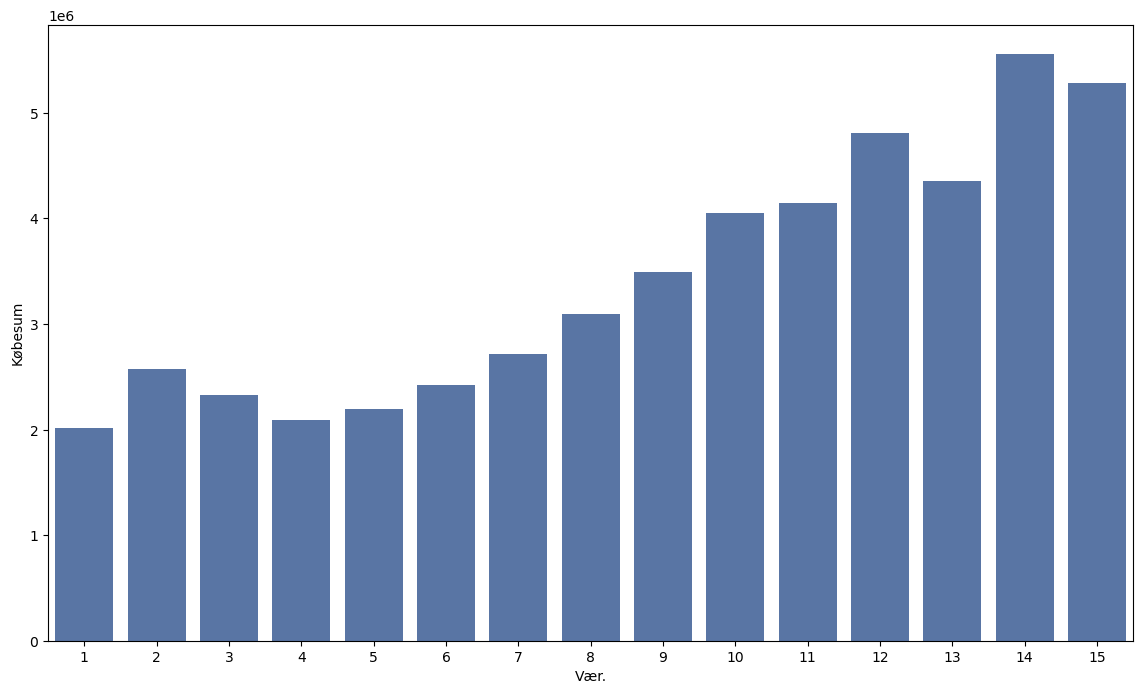

<Axes: xlabel='Vær.', ylabel='Købesum'>

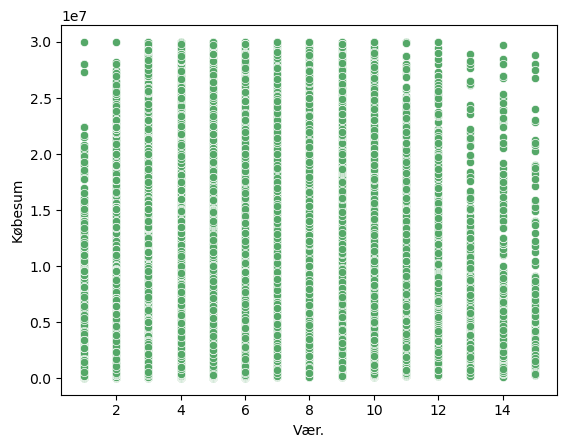

In [16]:
df.columns

Index(['Købesum', 'Vær.', 'Byggeår', 'stype', 'm2', 'btype', 'addresse',
       'postnummer', 'by', 'område', 'region', 'full_address', 'x', 'y',
       'pris_pr_m2', 'pris_pr_m2_mean_30D_by', 'pris_pr_m2_mean_180D_by',
       'pris_pr_m2_mean_365D_by', 'pris_pr_m2_mean_30D_postnummer',
       'pris_pr_m2_mean_180D_postnummer', 'pris_pr_m2_mean_365D_postnummer',
       'pris_pr_m2_mean_30D_område', 'pris_pr_m2_mean_180D_område',
       'pris_pr_m2_mean_365D_område', 'pris_pr_m2_mean_30D_region',
       'pris_pr_m2_mean_180D_region', 'pris_pr_m2_mean_365D_region',
       'num_actual_5_neighbors_for_stats', 'mean_of_5_neighbors_pris_pr_m2',
       'std_of_5_neighbors_pris_pr_m2', 'num_actual_10_neighbors_for_stats',
       'mean_of_10_neighbors_pris_pr_m2', 'std_of_10_neighbors_pris_pr_m2',
       'num_actual_25_neighbors_for_stats', 'mean_of_25_neighbors_pris_pr_m2',
       'std_of_25_neighbors_pris_pr_m2', 'num_actual_50_neighbors_for_stats',
       'mean_of_50_neighbors_pris_pr_m2', '

In [21]:
print(df.dtypes)

Købesum                                int64
Vær.                                   int64
Byggeår                                int64
stype                                 object
m2                                   float64
btype                                 object
addresse                              object
postnummer                             int64
by                                    object
område                                object
region                                object
full_address                          object
x                                    float64
y                                    float64
pris_pr_m2                           float64
pris_pr_m2_mean_30D_by               float64
pris_pr_m2_mean_180D_by              float64
pris_pr_m2_mean_365D_by              float64
pris_pr_m2_mean_30D_postnummer       float64
pris_pr_m2_mean_180D_postnummer      float64
pris_pr_m2_mean_365D_postnummer      float64
pris_pr_m2_mean_30D_område           float64
pris_pr_m2

In [15]:


def calculate_mi_scores(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    mi_scores = mutual_info_regression(X, y)

    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

print(calculate_mi_scores(df, 'Købesum'))

ValueError: could not convert string to float: 'Alm. Salg'